In [2]:
# ==== 1. SETUP & DATA PREP ============================================
# Install system dependencies first
!apt-get update -qq
!apt-get install -y poppler-utils

# Then install Python package
!pip install pdf2image

import os, shutil, pathlib
from pdf2image import convert_from_path

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.optimizers import Adam

DATA_ZIP = "/content/Redline_Markup_Complexity.zip"  # <- change if name differs
RAW_DIR  = "/content/raw_complexity"
IMG_DIR  = "/content/img_complexity"

# Unzip your uploaded dataset
!mkdir -p "$RAW_DIR"
!unzip -q "$DATA_ZIP" -d "$RAW_DIR"

RAW_DIR = pathlib.Path(RAW_DIR)
IMG_DIR = pathlib.Path(IMG_DIR)
IMG_DIR.mkdir(exist_ok=True, parents=True)

# Classes we expect
classes = ["Easy", "Medium", "Hard"]

# Convert PDFs -> PNGs (first page only) into IMG_DIR/Easy, IMG_DIR/Medium, IMG_DIR/Hard
for cls in classes:
    src_cls_dir = next(RAW_DIR.rglob(cls))  # find folder named "Easy"/"Medium"/"Hard"
    dst_cls_dir = IMG_DIR / cls
    dst_cls_dir.mkdir(exist_ok=True, parents=True)

    for f in src_cls_dir.iterdir():
        if not f.is_file():
            continue
        stem = f.stem

        if f.suffix.lower() == ".pdf":
            pages = convert_from_path(str(f), dpi=200)  # first page enough
            img = pages[0]
            out_path = dst_cls_dir / f"{stem}.png"
            img.save(out_path)
        else:
            # if already an image, just copy
            shutil.copy(str(f), str(dst_cls_dir / f.name))

print("Conversion done. Image folders:", list(IMG_DIR.glob("*")))

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.
Conversion done. Image folders: [PosixPath('/content/img_complexity/Medium'), PosixPath('/content/img_complexity/Easy'), PosixPath('/content/img_complexity/Hard')]


In [3]:
# ==== 2. DATASET PIPELINE ============================================

IMG_SIZE = (224, 224)
BATCH_SIZE = 4
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",   # ResNet expects 3 channels
    label_mode="int"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="int"
)

class_names = train_ds.class_names
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE

# Strong augmentation to fight overfitting
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="augmentation",
)

def preprocess(x, y):
    x = data_augmentation(x)
    x = resnet50.preprocess_input(x)
    return x, y

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (resnet50.preprocess_input(x), y)).prefetch(AUTOTUNE)


Found 56 files belonging to 3 classes.
Using 45 files for training.
Found 56 files belonging to 3 classes.
Using 11 files for validation.
Classes: ['Easy', 'Hard', 'Medium']


In [4]:
# ==== 3. MODEL: RESNET50 WITH SMALL HEAD ==============================

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling="avg",
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer=Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1,
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2852 - loss: 1.3533 - val_accuracy: 0.4545 - val_loss: 1.0286 - learning_rate: 0.0010
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.3497 - loss: 1.5279 - val_accuracy: 0.7273 - val_loss: 0.6840 - learning_rate: 0.0010
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.6890 - loss: 0.6952 - val_accuracy: 0.7273 - val_loss: 0.6156 - learning_rate: 0.0010
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.7728 - loss: 0.6760 - val_accuracy: 0.8182 - val_loss: 0.5670 - learning_rate: 0.0010
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.7132 - loss: 0.6909 - val_accuracy: 0.8182 - val_loss: 0.5229 - learning_rate: 0.0010
Epoch 6/30
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7624 - loss: 0.5684
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.7552 - loss: 0.5755 - val

In [5]:
# ==== 4. FINE-TUNE LAST BLOCKS (SMALL LR) ============================

for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),  # lower LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=1,
)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7689 - loss: 0.5898 - val_accuracy: 0.7273 - val_loss: 0.5687 - learning_rate: 1.0000e-05
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.5886 - loss: 0.7692 - val_accuracy: 0.8182 - val_loss: 0.5712 - learning_rate: 1.0000e-05
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.7097 - loss: 0.7928 - val_accuracy: 0.8182 - val_loss: 0.5673 - learning_rate: 1.0000e-05
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6884 - loss: 0.6538
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - accuracy: 0.6885 - loss: 0.6505 - val_accuracy: 0.8182 - val_loss: 0.5565 - learning_rate: 1.0000e-05
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.7151 - loss: 0.6092 - val_accuracy: 0.8182 - val_loss: 0.5437 - learning_rate: 5.0000e-06
Epoch 6/20
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7872 

In [6]:
# ==== 5. EVALUATE & SAVE ============================================

val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy: {val_acc:.3f}")

# Map class index -> label
print("Class index mapping:", dict(enumerate(class_names)))

# Save model (for PyCharm / Streamlit)
MODEL_PATH = "/content/resnet50_complexity.h5"
model.save(MODEL_PATH)
print("Saved model to:", MODEL_PATH)


Validation accuracy: 0.818
Class index mapping: {0: 'Easy', 1: 'Hard', 2: 'Medium'}
Saved model to: /content/resnet50_complexity.h5


Saving Sample E-1.pdf to Sample E-1.pdf

===== Sample E-1.pdf =====


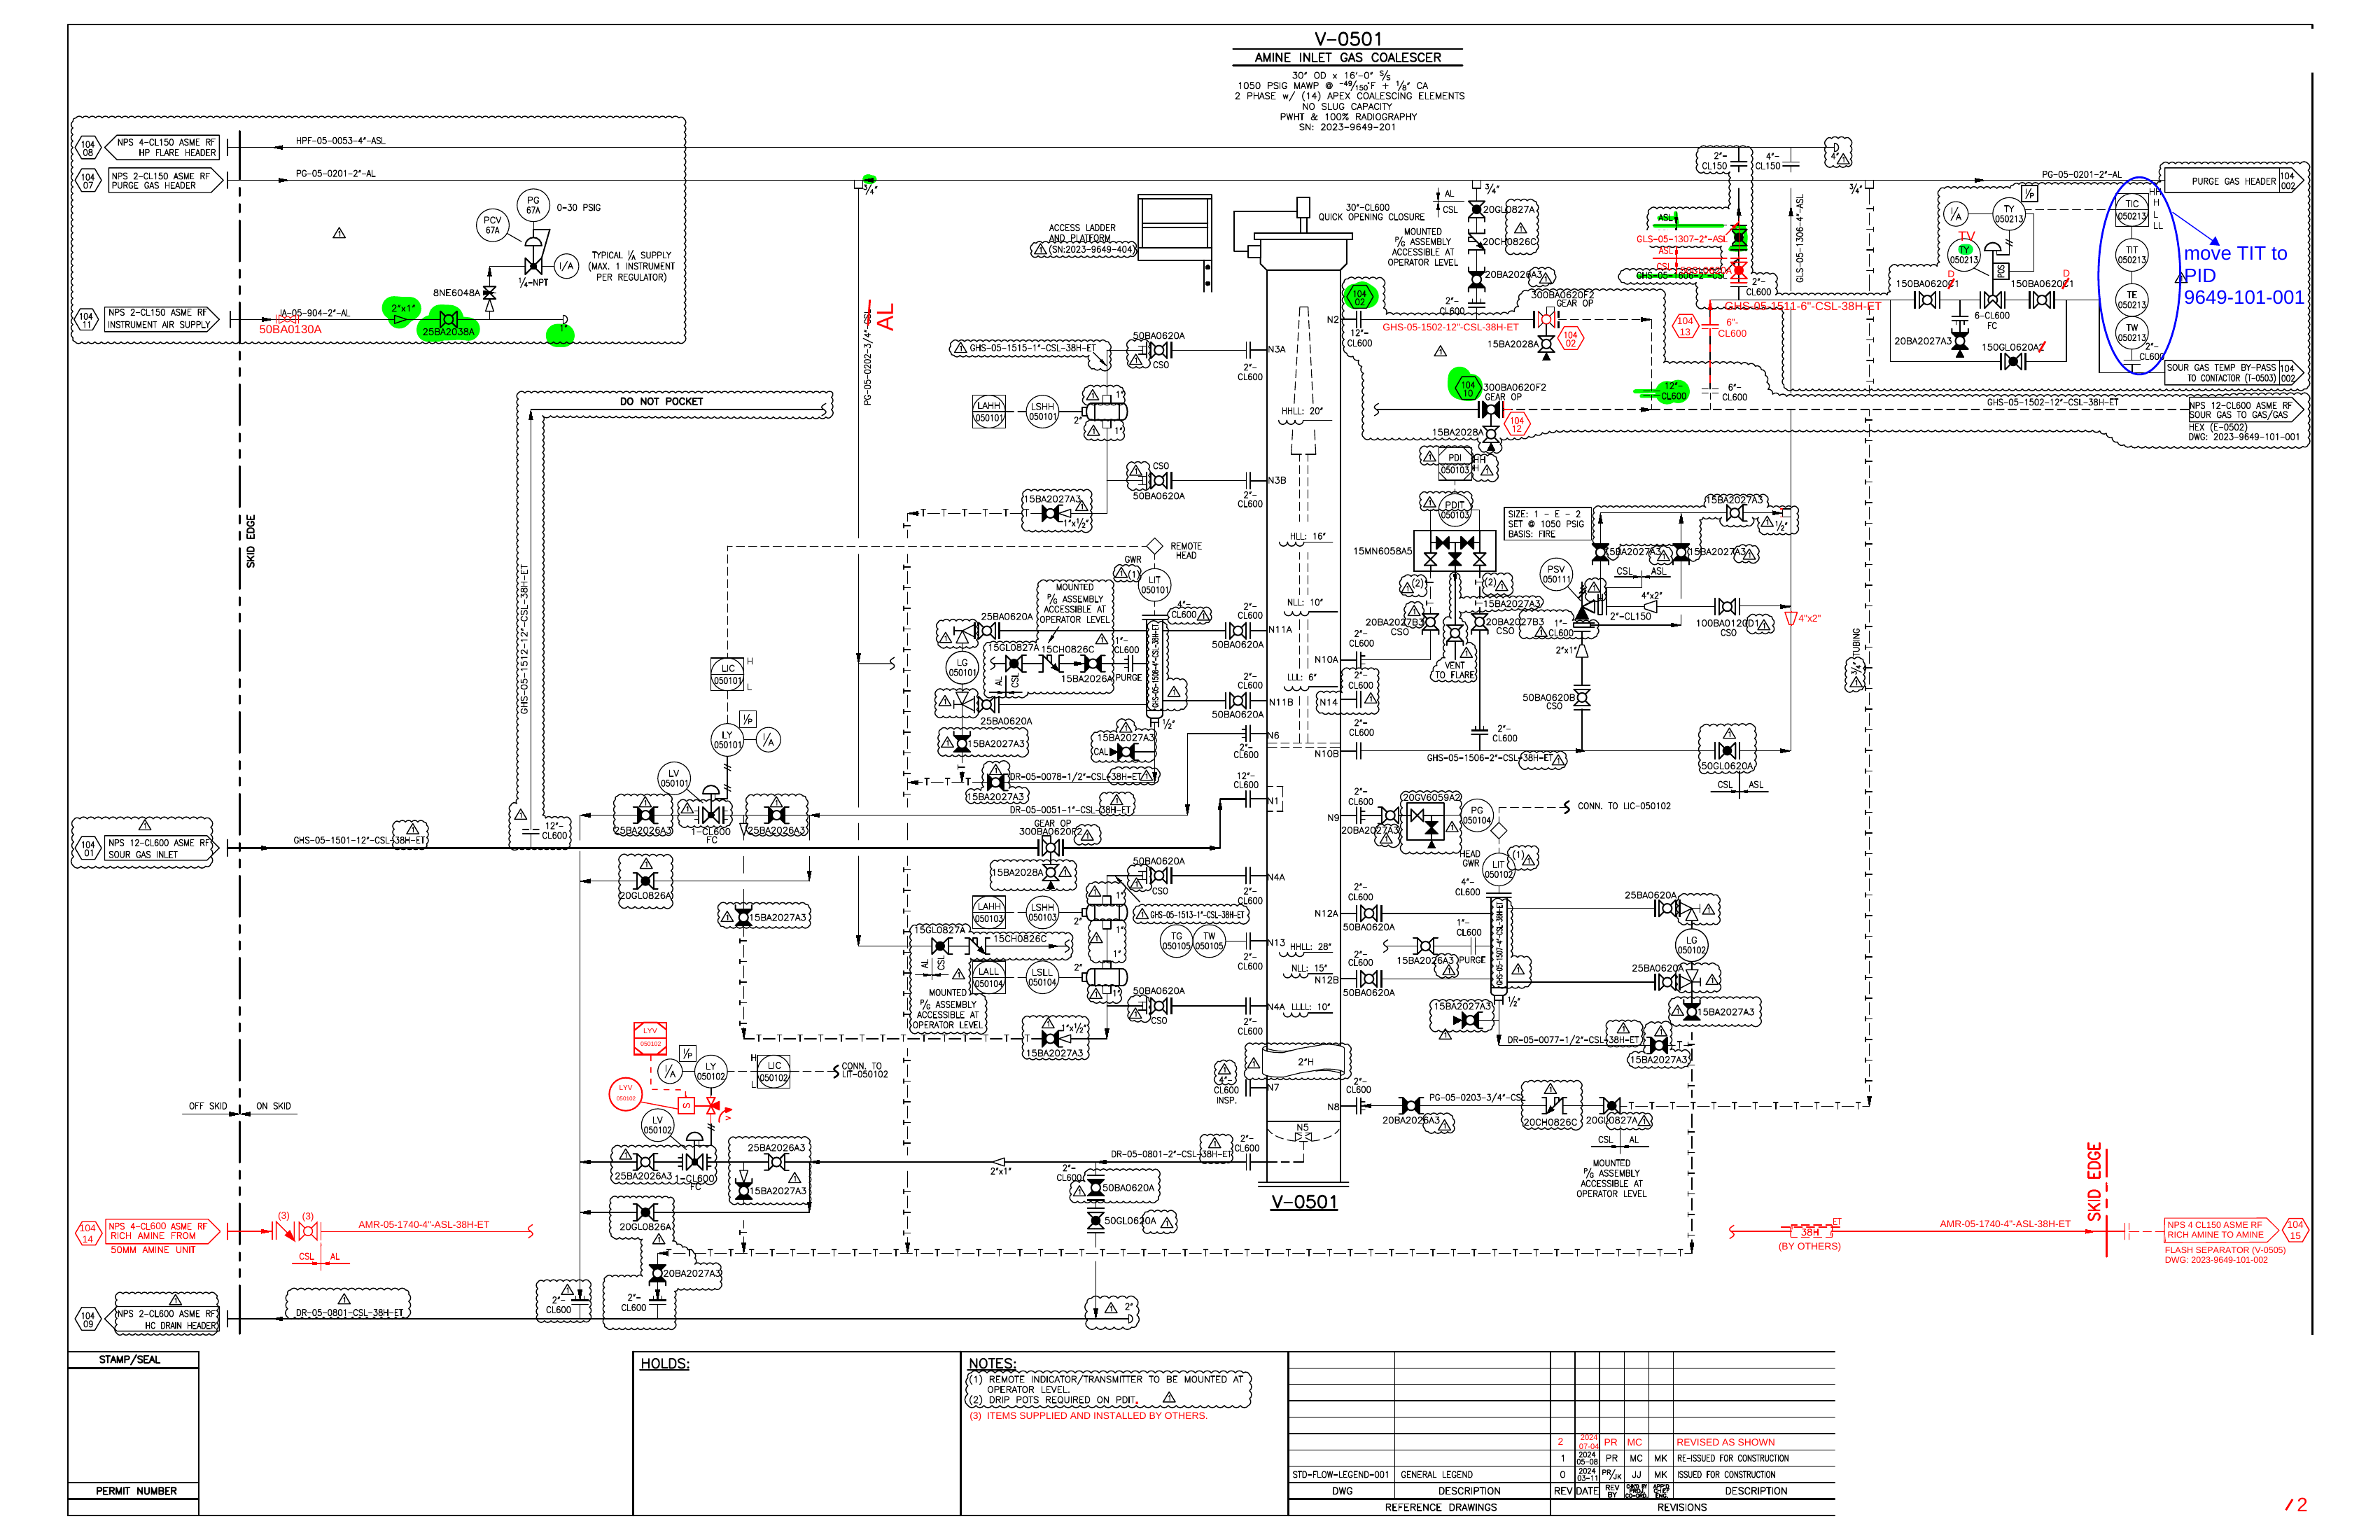

Predicted complexity : Hard (44.5% confidence)
Estimated effort     : 12.0 hours
Estimated labour cost: $780.00


In [10]:
# @title 10) Upload your own drawing and get complexity + hours + cost
from google.colab import files
from PIL import Image
import io
import numpy as np

# --- Business mapping (tweak if you like) ---
CLASS_NAMES = ["Easy", "Medium", "Hard"]     # same order as your model output
HOURS_MAP = {                                # effort per class
    "Easy":   3.0,
    "Medium": 6.0,
    "Hard":   12.0,
}
RATE_PER_HOUR = 65.0                         # $ per hour

def preprocess_image_pil(pil_img, img_size=(224, 224)):
    """Pad to square, resize, normalize like training."""
    pil_img = pil_img.convert("RGB")
    w, h = pil_img.size
    side = max(w, h)

    # pad to square with white background
    square = Image.new("RGB", (side, side), (255, 255, 255))
    square.paste(pil_img, ((side - w)//2, (side - h)//2))

    # Fix: ensure img_size is a tuple of two integers
    if isinstance(img_size, tuple):
        target_size = img_size
    else:
        target_size = (img_size, img_size)

    square = square.resize(target_size, Image.LANCZOS)
    arr = np.array(square) / 255.0
    return np.expand_dims(arr, axis=0)

uploaded = files.upload()

for filename, data in uploaded.items():
    print(f"\n===== {filename} =====")

    # Load image (if it's a PDF, take first page as image)
    if filename.lower().endswith(".pdf"):
        from pdf2image import convert_from_bytes
        pages = convert_from_bytes(data)
        pil_img = pages[0]          # first page
    else:
        pil_img = Image.open(io.BytesIO(data))

    # Preprocess + predict
    x = preprocess_image_pil(pil_img)
    predictions = model.predict(x, verbose=0)

    # Handle single output (classification only)
    if isinstance(predictions, list) and len(predictions) == 2:
        cls_pred, reg_pred = predictions
        reg_score = float(reg_pred[0][0])
    else:
        cls_pred = predictions
        reg_score = None

    cls_idx = int(np.argmax(cls_pred[0]))
    cls_name = CLASS_NAMES[cls_idx]
    confidence = float(cls_pred[0][cls_idx]) * 100
    hours = HOURS_MAP[cls_name]
    cost = hours * RATE_PER_HOUR

    # Show image + results
    display(pil_img)
    print(f"Predicted complexity : {cls_name} ({confidence:.1f}% confidence)")
    print(f"Estimated effort     : {hours:.1f} hours")
    print(f"Estimated labour cost: ${cost:.2f}")
    if reg_score is not None:
        print(f"Continuous score     : {reg_score:.3f}")